## Install statsbombpy library

In [1]:
pip install statsbombpy


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import sb from statsbombpy

In [2]:
from statsbombpy import sb

# Determine starting conditions
## This notebook is very general in it's format, fill in the following below and every cell will run without any other modifications needed:
Variables to fill out:
1. match_id

In [90]:
# match_id = 18245 was Real-Madrid vs liverpool in the champions league final 2018-05-26
# match_id = 9924 was Real-Madrid vs Barcelona in La Liga 2017/2018 (2018-05-06)
# match_id = 9736 was Real-Madrid vs Barcelona in La Liga 2017/2018 (2017-12-23)
# match_id = 267569 was Real-Madrid vs Barcelona in La Liga 2016/1017 (2017-04-23)
# match_id = 267076 was Real-Madrid vs Barcela in La Liga 2016/2017 (2016-12-03)
match_id = 18245

## Select the event
### ie. select all the data from the match with match id = ...

In [91]:
# Select the match
events=sb.events(match_id=match_id)

# Get the team info
teams = events['team'].unique()
team1 = teams[0]
team2 = teams[1]

## Create a list for each teams starting XI

In [92]:
# Getting team 1's starting XI
team1_data = events.loc[events['team'] == team1]
team1_starting_xi_data = team1_data.loc[events['type'] == 'Starting XI']

team1_starting_xi = []
for player in team1_starting_xi_data['tactics'][0]['lineup']:
    team1_starting_xi.append(player['player']['name'])
    
    
# Getting team 2's starting XI
team2_data = events.loc[events['team'] == team2]
team2_starting_xi_data = team2_data.loc[events['type'] == 'Starting XI']

team2_starting_xi = []
for player in team2_starting_xi_data['tactics'][1]['lineup']:
    team2_starting_xi.append(player['player']['name'])

## Massage the data (Split the data into two dataframes, one for each team, and only keep relevant columns)
### Relevant columns are:
- location (starting location of pass)
- pass_end_location (ending location of pass)
- team
- player
- pass recipient
- timestamp

In [93]:
all_events_df = events[['location', 'pass_end_location', 'team', 'player', 'pass_recipient', 'timestamp']].dropna()

team1_df = all_events_df.loc[all_events_df['team'] == team1].reset_index(drop=True)
team2_df = all_events_df.loc[all_events_df['team'] == team2].reset_index(drop=True)

## Import pandas so we can work with the dataframe

In [94]:
import pandas as pd

## Split location and pass_end location columns into 2 columns each
### These columns being:
- Split location into start_x, start_y
- Split pass_end_location into end_x, end_y

In [95]:
# Splitting columns for team 1
team1_pass_start_df = pd.DataFrame(team1_df['location'].to_list(), columns=['start_x', 'start_y']).reset_index(drop=True)
team1_df_final = team1_df.join(team1_pass_start_df)
team1_pass_end_df = pd.DataFrame(team1_df['pass_end_location'].to_list(), columns=['end_x', 'end_y']).reset_index(drop=True)
team1_df_final = team1_df_final.join(team1_pass_end_df)

# Splitting columns for team 2
team2_pass_start_df = pd.DataFrame(team2_df['location'].to_list(), columns=['start_x', 'start_y']).reset_index(drop=True)
team2_df_final = team2_df.join(team2_pass_start_df)
team2_pass_end_df = pd.DataFrame(team2_df['pass_end_location'].to_list(), columns=['end_x', 'end_y']).reset_index(drop=True)
team2_df_final = team2_df_final.join(team2_pass_end_df)

## Massage the dataframes more so we are left with these columns:
- player
- pass_recipient
- start_x
- start_y
- end_x
- end_y

In [96]:
# Dropping irrelevant columns for team 1
team1_df_final = team1_df_final.drop(columns=['location', 'pass_end_location', 'timestamp', 'team'])

# Dropping irrelevant columns for team 2
team2_df_final = team2_df_final.drop(columns=['location', 'pass_end_location', 'timestamp', 'team'])

## Drop the rows which don't contain players in the starting XI, we are not interested in data about substitutes

In [97]:
# Only keeping rows which contain players in the starting XI
team1_df_final = team1_df_final[team1_df_final['player'].isin(team1_starting_xi)]
team1_df_final = team1_df_final[team1_df_final['pass_recipient'].isin(team1_starting_xi)]
positions = []
for player in team1_df_final['player']:
    for player2 in team1_starting_xi_data['tactics'][0]['lineup']:
        if (player == player2['player']['name']):
            positions.append(player2['position'])

team1_df_final['position'] = positions

positions = []
for player in team1_df_final['pass_recipient']:
    for player2 in team1_starting_xi_data['tactics'][0]['lineup']:
        if (player == player2['player']['name']):
            positions.append(player2['position'])

team1_df_final['pass_recipient_position'] = positions
# print(team1_df_final)

# Only keeping rows which contain players in the starting XI
team2_df_final = team2_df_final[team2_df_final['player'].isin(team2_starting_xi)]
# print(team2_df_final)

## Massage the data even more to have average start_x and start_y columns. This the the position on the field (in our graph), these nodes will be placed

### The final dataframes will have these columns:
- player
- start_x (an average of all this players start_x positions)
- start_y (an average of all this players start_y positions)

In [98]:
# Massage data as described above for team 1
team1_average_df = team1_df_final.groupby('player').agg({'start_x': 'mean', 'start_y': 'mean'}).reset_index()
positions = []
for player in team1_average_df['player']:
    for player2 in team1_starting_xi_data['tactics'][0]['lineup']:
        if (player == player2['player']['name']):
            positions.append(player2['position'])

team1_average_df['position'] = positions
# print(team1_average_df)


# Massage data as described above for team 1
team2_average_df = team2_df_final.groupby('player').agg({'start_x': 'mean', 'start_y': 'mean'}).reset_index()
# positions = []
# for player in team2_average_df['player']:
#     for player2 in team2_starting_xi_data['tactics'][1]['lineup']:
#         if (player == player2['player']['name']):
#             positions.append(player2['position'])

# team2_average_df['position'] = positions
# team2_average_df

In [99]:
# Adding each players position id

## Now it's time to make the graphs
### The graph should be created as follows:
- One directed graph for each team
    - Each node represents a player on a team's starting XI
        - Nodes are position according to the players average start_x and start_y position
    - An edge exists between two nodes (players) IF, in the match one played a pass to another
        - Add weights to edges: The weight of an edge is the total number of passes a player played to another throughout the match

In [100]:
import networkx as nx

# Create graph for team 1
G1 = nx.DiGraph()

# Add nodes with player names and their average starting positions
for index, row in team1_average_df.iterrows():
    G1.add_node(row['player'], x=row['start_x'], y=row['start_y'], position=row['position'])
#     G1.add_node(row['position']['id'], x=row['start_x'], y=row['start_y'], position=row['position'], name=row['player'])
    
for index, row in team1_df_final.iterrows():
    player = row['player']
#     player = row['position']['id']
    pass_recipient = row['pass_recipient']

    if G1.has_node(player) and G1.has_node(pass_recipient):
        if G1.has_edge(player, pass_recipient):
            # Edge already exists, increment the weight
            G1[player][pass_recipient]['weight'] += 1
        else:
            # Edge doesn't exist, create it with weight 1
            G1.add_edge(player, pass_recipient, weight=1)
            

# Create graph for team 2
G2 = nx.DiGraph()

# Add nodes with player names and their average starting positions
for index, row in team2_average_df.iterrows():
    G2.add_node(row['player'], x=row['start_x'], y=row['start_y'])
    
for index, row in team2_df_final.iterrows():
    player = row['player']
    pass_recipient = row['pass_recipient']

    if G2.has_node(player) and G2.has_node(pass_recipient):
        if G2.has_edge(player, pass_recipient):
            # Edge already exists, increment the weight
            G2[player][pass_recipient]['weight'] += 1
        else:
            # Edge doesn't exist, create it with weight 1
            G2.add_edge(player, pass_recipient, weight=1)

## Install todofcpy so that we can create a nice visualization

In [101]:
pip install todofcpy


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Time to make the plot. 
### Here is the step by step:
- Create a dictionary with keys for each node (player) and the values being a tuple for their average start_x and average start_y position
- Create a dictionary for the edge labels (weights)
- Create a field from todofcpy.visualization.graph
- Use networkx to draw our graph onto the field

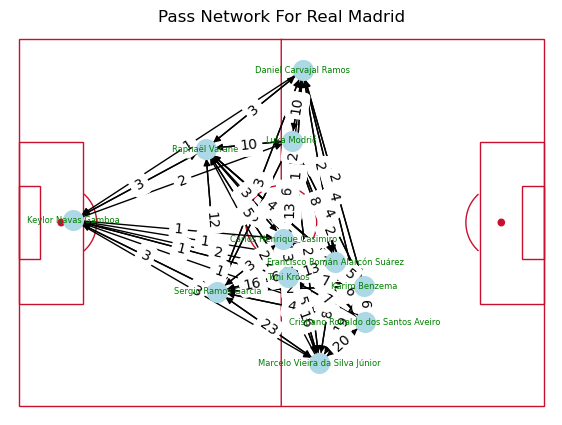

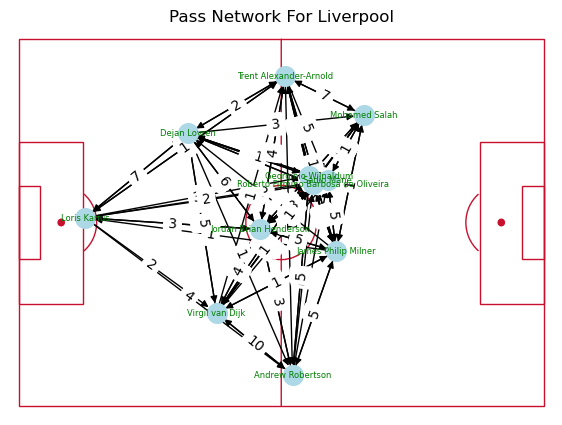

In [102]:
import matplotlib.pyplot as plt
from todofcpy.visualization.graph import Field

# Network visualization for team 1
pos = {player: (team1_average_df.loc[team1_average_df['player'] == player, 'start_x'].values[0], 
                team1_average_df.loc[team1_average_df['player'] == player, 'start_y'].values[0])
                for player in G1.nodes()}
edge_labels = {(u, v): d['weight'] for u, v, d in G1.edges(data=True)}

field = Field()
plt = field.create_field(grass='#FFFFFF', lines = '#C8102E')

nx.draw(G1, pos, with_labels=True, node_size=200, font_size=6, node_color='lightblue', font_color='green')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)
plt.title("Pass Network For " + team1)
plt.show()

# Network visualization for team 2
pos2 = {player: (team2_average_df.loc[team2_average_df['player'] == player, 'start_x'].values[0], 
                team2_average_df.loc[team2_average_df['player'] == player, 'start_y'].values[0])
                for player in G2.nodes()}
edge_labels2 = {(u, v): d['weight'] for u, v, d in G2.edges(data=True)}


field2 = Field()
plt2 = field2.create_field(grass='#FFFFFF', lines = '#C8102E')

nx.draw(G2, pos2, with_labels=True, node_size=200, font_size=6, node_color='lightblue', font_color='green')
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=edge_labels2)
plt2.title("Pass Network For " + team2)
plt2.show()

In [103]:
# # ALTERNATIVE PLOT TO SHOW EVERY PASS IN THE MATCH FROM TEAM 1
# field = Field()
# plt = field.create_field(grass='#FFFFFF', lines = '#C8102E')
# plt1 = plt.plot((team1_df_final['start_x'], team1_df_final['start_y']), (team1_df_final['end_x'], team1_df_final['end_y']), marker='o', markevery=[0])
# # plt1.show()

## Let's do some community detection
### Using the Louvain algorithm, we can find the optimal partition which takes into account edge-weights

In [122]:
import networkx.algorithms.community.louvain as louvain

partition1 = louvain.louvain_communities(G1, weight='weight')
print(partition1)

partition2 = louvain.louvain_communities(G2, weight='weight')
print(partition2)

[{'Daniel Carvajal Ramos', 'Carlos Henrique Casimiro', 'Luka Modrić'}, {'Cristiano Ronaldo dos Santos Aveiro', 'Marcelo Vieira da Silva Júnior', 'Toni Kroos', 'Karim Benzema', 'Francisco Román Alarcón Suárez'}, {'Sergio Ramos García', 'Raphaël Varane', 'Keylor Navas Gamboa'}]
[{'Virgil van Dijk', 'Andrew Robertson', 'Jordan Brian Henderson', 'James Philip Milner', 'Sadio Mané'}, {'Loris Karius', 'Dejan Lovren'}, {'Mohamed Salah', 'Georginio Wijnaldum', 'Trent Alexander-Arnold', 'Roberto Firmino Barbosa de Oliveira'}]


## Now let's do some Motif Detection
1. Download sageMath from https://github.com/3-manifolds/Sage_macOS/releases
2. Run the sage-math application from the applciations folder, and open this notebook from within that application
3. Now we are ready, let's count the occurences of all the size 3 motifs in our network (one team's pass map)


In [124]:
import numpy
from sage.graphs.graph import DiGraph

size_3_motifs = [
    [(1, 0), (1, 2)],
    [(1, 0), (2, 1)],
    [(1, 0), (1, 2), (2, 1)],
    [(1, 0), (2, 0)],
    [(1, 0), (1, 2), (2, 1)],
    [(1, 0), (1, 2), (2, 1), (2, 0)],
    [(0, 1), (1, 2), (2, 1)],
    [(0, 1), (1, 0), (1, 2), (2, 1)],
    [(0, 1), (1, 2), (2, 0)],
    [(0, 1), (1, 0), (1, 2), (2, 0)],
    [(0, 1), (1, 0), (2, 1), (2, 0)],
    [(0, 1), (1, 0), (1, 2), (2, 1), (2, 0)],
    [(0, 1), (1, 0), (1, 2), (2, 1), (2, 0), (0, 2)]
]

M1 = DiGraph(size_3_motifs[0])
M2 = DiGraph(size_3_motifs[1])
M3 = DiGraph(size_3_motifs[2])
M4 = DiGraph(size_3_motifs[3])
M5 = DiGraph(size_3_motifs[4])
M6 = DiGraph(size_3_motifs[5])
M7 = DiGraph(size_3_motifs[6])
M8 = DiGraph(size_3_motifs[7])
M9 = DiGraph(size_3_motifs[8])
M10 = DiGraph(size_3_motifs[9])
M11 = DiGraph(size_3_motifs[10])
M12 = DiGraph(size_3_motifs[11])
M13 = DiGraph(size_3_motifs[12])



G1_edgelist = list(G1.edges)
G1_digraph = DiGraph(G1_edgelist)


l1 = []
for p in G1_digraph.subgraph_search_iterator(M1, induced=True):
  l1.append(p)

# print("M1 occurences = ")
# print(len(l1))

l2 = []
for p in G1_digraph.subgraph_search_iterator(M2, induced=True):
  l2.append(p)

# print("M2 occurences = ")
# print(len(l2))

l3 = []
for p in G1_digraph.subgraph_search_iterator(M3, induced=True):
  l3.append(p)

# print("M3 occurences = ")
# print(len(l3))

l4 = []
for p in G1_digraph.subgraph_search_iterator(M4, induced=True):
  l4.append(p)

# print("M4 occurences = ")
# print(len(l1))

l5 = []
for p in G1_digraph.subgraph_search_iterator(M5, induced=True):
  l5.append(p)

# print("M5 occurences = ")
# print(len(l1))

l1 = []
for p in G1_digraph.subgraph_search_iterator(M6, induced=True):
  l1.append(p)

# print("M6 occurences = ")
# print(len(l1))

l1 = []
for p in G1_digraph.subgraph_search_iterator(M7, induced=True):
  l1.append(p)

# print("M7 occurences = ")
# print(len(l1))

l1 = []
for p in G1_digraph.subgraph_search_iterator(M8, induced=True):
  l1.append(p)

# print("M8 occurences = ")
# print(len(l1))

l1 = []
for p in G1_digraph.subgraph_search_iterator(M9, induced=True):
  l1.append(p)

# print("M9 occurences = ")
# print(len(l1))

l1 = []
for p in G1_digraph.subgraph_search_iterator(M10, induced=True):
  l1.append(p)

# print("M10 occurences = ")
# print(len(l1))

l1 = []
for p in G1_digraph.subgraph_search_iterator(M11, induced=True):
  l1.append(p)

# print("M11 occurences = ")
# print(len(l1))

l1 = []
for p in G1_digraph.subgraph_search_iterator(M12, induced=True):
  l1.append(p)

# print("M12 occurences = ")
# print(len(l1))

l1 = []
for p in G1_digraph.subgraph_search_iterator(M13, induced=True):
  l1.append(p)

# print("M13 occurences = ")
# print(len(l1))

## After some magic, ie running the above for all 5 games and storing the results in excel, we can create a DataFrame with the data
### With this DataFrame, we can represent the data in a plot

In [112]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 251.7 kB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


   Motif  267076  267569  9736  9924  18245
0     M1       0       0     0     2      0
1     M2       0       0     1     1      1
2     M3       2       8     7     4      0
3     M4       0       0     0     2      0
4     M5       0       0     0     2      0
5     M6       8       8     4     6      2
6     M7       4      10     8    13      2
7     M8       4      30    28    18     12
8     M9       0       0     0     0      0
9    M10       9       4     5     7      6
10   M11      20       8     2    20     30
11   M12      42      58    30    52     39
12   M13     540     348   564   360    564


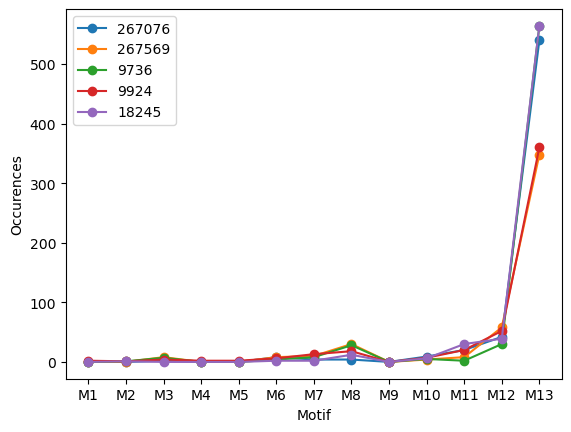

In [121]:
import pandas as pd

motif_df = pd.read_excel('Motif Occurences.xlsx')

print(motif_df)

plt.plot(motif_df['Motif'], motif_df[267076], label='267076', marker='o')
plt.plot(motif_df['Motif'], motif_df[267569], label='267569', marker='o')
plt.plot(motif_df['Motif'], motif_df[9736], label='9736', marker='o')
plt.plot(motif_df['Motif'], motif_df[9924], label='9924', marker='o')
plt.plot(motif_df['Motif'], motif_df[18245], label='18245', marker='o')

plt.xlabel('Motif')
plt.ylabel('Occurences')
plt.legend()

plt.show()

## This plot is nice... But isn't there a better way to visualize the data? YES! Create a network significance profile by creating a vector of normalized Z-scores of how our data compares to that of a random graph

In [ ]:
# TO BE COMPLETED